In [1]:
import torch
import numpy as np
import pyvista as pv
import Ofpp
from utils.visualizer import *
pv.set_jupyter_backend('static') 

import sys
import os
sys.path.insert(0, r'C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Torch_VFM')
from src.utils.mesh_utils import *
from src.utils.data_utils import get_bc_dict
from src.gauss_green import gaus_green_vfm_mesh
from src.physics.operators import *

dtype = torch.float32

In [5]:
def load_case_mesh(dir, bc_dict):
    vtk_file_reader = pv.POpenFOAMReader(dir)

    # Get Mesh
    mesh = gaus_green_vfm_mesh(vtk_file_reader, dtype = dtype, bc_dict=bc_dict)

    # Get Ground Truth Data
    vtk_file_reader.set_active_time_value(vtk_file_reader.time_values[-1])
    vtk_file_reader.cell_to_point_creation = False
    vtk_file_reader.enable_all_patch_arrays()
    vtk_mesh = vtk_file_reader.read()[0]
    U_gt = torch.tensor(vtk_mesh['U'], dtype = dtype).unsqueeze(0).unsqueeze(0)
    return mesh, vtk_mesh, U_gt

In [6]:
U_bc_dict = {
            'movingWall':{ "type":'fixedValue', "value":[1,0,0]},
            'fixedWalls':{ "type":'fixedValue', "value":[0,0,0]},  
            'frontAndBack':{ "type":'empty'}    
            }
p_bc_dict = {
    'movingWall':{ "type":'zeroGradient' },
    'fixedWalls':{ "type":'zeroGradient' },  
    'frontAndBack':{ "type":'empty'}    
}
bc_dict = {'U':U_bc_dict, 'p':p_bc_dict}

nu = 0.01

In [7]:
dir = r'C:\Users\Noahc\Documents\USYD\tutorial\cavity_sparse\case.foam'
mesh, vtk_mesh, U_gt =  load_case_mesh(dir, bc_dict)

Calculating face centers and areas for 4160 faces
{'max_non_orthogonality': 0.0, 'avg_non_orthogonality': 0.0, 'max_skewness': 2.3841880647523794e-06, 'avg_skewness': 2.975726260956435e-07}
 Found Patch "movingWall" with 32 Faces
 Found Patch "fixedWalls" with 96 Faces
Boundary faces indexed: 128/2176 patches found
Calculating Cell2Cell at Face Linear Interpolation Weights (L2):
  min w:0.5000,               max w:0.5000,               mean w:0.5000


In [8]:
divU_pred, gradU_pred = Divergence_Operator.caclulate(mesh, field=U_gt)
lap_pred = Laplacian_Operator.caclulate(mesh, field=U_gt)*nu

In [9]:
gradU_gt = torch.tensor(vtk_mesh['grad(U)'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)
lapU_gt = torch.tensor(vtk_mesh['lapU'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)
divU_gt = torch.tensor(vtk_mesh['divU_phiAll'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)

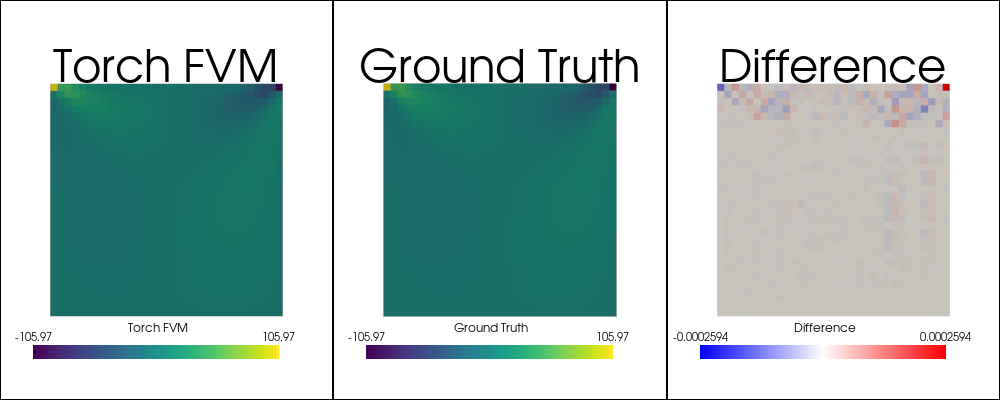

In [10]:
names = ['dudx', 'dudy', 'dvdx', 'dvdy']
#for i, j in enumerate([0,1,3,4]):
for i, j in enumerate([0]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',i=j, interactive = True, point_label=False,
                    prediction=gradU_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = gradU_gt.squeeze(0).squeeze(0).numpy(),
                    )

In [14]:
def navier_stokes_2d(solution_field:torch.tensor, solution_index:dict, Re:torch.tensor, time_derivative:torch.tensor=None) -> torch.tensor:
    assert len(Re.shape) == len(solution_field.shape), f'{Re.shape} vs {solution_field.shape}'
    assert len(solution_field.shape) == 4, 'Solution field should be [batch, time-step, cells, channels]'

    B, T, N, C = solution_field.shape

    # Unflatten and pad with ghost nodes (assuming Isometric grid)
    H = W = int(N**0.5)
    assert H * W == N, "N must be a perfect square"
    solution_field = solution_field.view(B, T, H, W, C)
    solution_field = torch.nn.functional.pad(solution_field, (0,0,1,1,1,1))
    
    # assume dx based on unit length domain (specific to cavity case)
    dx = dy = 1/(H-1)

    # split into components
    p = solution_field[...,solution_index['p']]
    U = solution_field[...,solution_index['U']]
    assert U.shape[-1] == 2, 'Expecting a 2D field'

    # Fill out ghost nodes based on boundary conditions (hard coded)
    # Lid
    U[:,-1  , :  , 0] = -U[:,-2  , :  , 0] + 2.0
    U[:,-1  , :  , 1] = -U[:,-2  , :  , 1] 
    p[:,-1  , :  , 0] =  p[:,-2  , :  , 0]

    # Left Wall
    U[:, :  , 0  , :2] = -U[:, :  , 1  , :2]
    p[:, :  , 0  , 0]  =  p[:, :  , 1  , 0]

    # Bottom Wall
    U[:, 0  , :  , :2] = -U[:, 1  , :  , :2]
    p[:, 0  , :  , 0] =  p[:, 1  , :  , 0]

    # Right Wall
    U[:, :  ,-1  , :2] = -U[:, :  ,-2  , :2]
    p[:, :  ,-1  , 0] =   p[:, :  ,-2  , 0]

    # gradients in internal zone
    u_y  = (U[:, 2:  , 1:-1, 0] -   U[:,  :-2, 1:-1, 0]) / (2*dy)
    u_x  = (U[:, 1:-1, 2:  , 0] -   U[:, 1:-1,  :-2, 0]) / (2*dx)
    u_yy = (U[:, 2:  , 1:-1, 0] - 2*U[:, 1:-1, 1:-1, 0] + U[:,  :-2, 1:-1, 0]) / (dy**2)
    u_xx = (U[:, 1:-1, 2:  , 0] - 2*U[:, 1:-1, 1:-1, 0] + U[:, 1:-1,  :-2, 0]) / (dx**2)

    v_y  = (U[:, 2:  , 1:-1, 1] -   U[:,  :-2, 1:-1, 1]) / (2*dy)
    v_x  = (U[:, 1:-1, 2:  , 1] -   U[:, 1:-1,  :-2, 1]) / (2*dx)
    v_yy = (U[:, 2:  , 1:-1, 1] - 2*U[:, 1:-1, 1:-1, 1] + U[:,  :-2, 1:-1, 1]) / (dy**2)
    v_xx = (U[:, 1:-1, 2:  , 1] - 2*U[:, 1:-1, 1:-1, 1] + U[:, 1:-1,  :-2, 1]) / (dx**2)

    p_y  = (p[:, 2:  , 1:-1, 0] - p[:,  :-2, 1:-1, 0]) / (2*dy)
    p_x  = (p[:, 1:-1, 2:  , 0] - p[:, 1:-1,  :-2, 0]) / (2*dx)

    # Equations
    f0 = u_x + v_y
    f1 = U[:,1:-1,1:-1, 0]*u_x + U[:,1:-1,1:-1, 1]*u_y - (1/Re) * (u_xx + u_yy) + p_x
    f2 = U[:,1:-1,1:-1, 0]*v_x + U[:,1:-1,1:-1, 1]*v_y - (1/Re) * (v_xx + v_yy) + p_y

    f0 = f0.view(B, T, H * W)
    f1 = f1.view(B, T, H * W)
    f2 = f2.view(B, T, H * W)

    equations = {'Continuity':f0, 'X-momentum':f1, 'Y-momentum':f2}

navier_stokes_2d(solution_field=U_gt, solution_index={'U':[0,1], 'p':[2]}, Re=torch.tensor(1/nu).reshape(-1,1,1))

AssertionError: torch.Size([1, 1, 1]) vs torch.Size([1, 1, 1024, 3])